# Causal Inference over a Causal Graph

In [44]:
from IPython.display import clear_output

In [45]:
!pip install dowhy
!pip install gcastle
!pip install econml
!pip install shap
clear_output()

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dowhy import CausalModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import clear_output

In [4]:
np.random.seed(0)

## 1. Synthetic data generation

In [37]:
# Note (1): lv0 features may affect both targets an other features of lv1
# Note (2): col_targets are leaf nodes that do not affect oneanother

SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(SAMPLE_SIZE)
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3
    }
    )
df.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,2024-01-01,0.537567,0.890223,0.453381,0.346586,0.557576,0.077025,0.366967,0.392658,-0.033719
1,2024-01-02,0.082682,0.075461,0.013333,0.236928,0.135521,0.192334,0.125888,0.183667,-0.055099
2,2024-01-03,0.412238,0.274155,0.746969,0.370587,0.593968,0.448208,0.335355,0.351520,-0.183364
3,2024-01-04,0.739469,0.996203,0.312167,0.558377,0.528433,0.330599,0.463689,0.529776,-0.304824
4,2024-01-05,0.751423,0.667976,0.290538,0.762738,0.513894,0.479225,0.582136,0.501003,-0.309168


## 2. GCM API

### 2.1. Define the Causal Graph

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [39]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [40]:
# Define graph dependencies
edges = [
    ('col_feature1_lv0', 'col_feature4_lv1'),
    ('col_feature1_lv0', 'col_feature5_lv1'),
    ('col_feature1_lv0', 'col_target1'),
    ('col_feature1_lv0', 'col_target2'),
    ('col_feature1_lv0', 'col_target3'),

    ('col_feature2_lv0', 'col_feature5_lv1'),
    ('col_feature2_lv0', 'col_target1'),
    ('col_feature2_lv0', 'col_target2'),
    ('col_feature2_lv0', 'col_target3'),

    ('col_feature3_lv0', 'col_feature5_lv1'),
    ('col_feature3_lv0', 'col_feature6_lv1'),
    ('col_feature3_lv0', 'col_target1'),

    ('col_feature4_lv1', 'col_target1'),

    ('col_feature5_lv1', 'col_target2'),
    ('col_feature5_lv1', 'col_target3'),

    ('col_feature6_lv1', 'col_target2')
    ]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

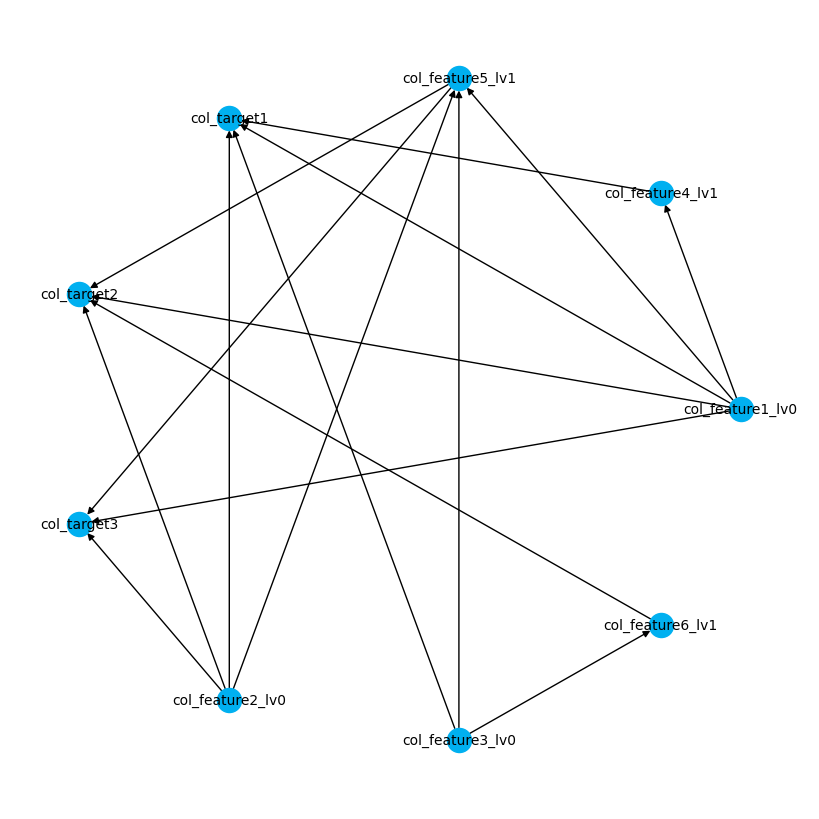

In [41]:
'''
nx.draw(
    graph_nx,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
'''
# larger figure size
plt.figure(3,figsize=(8,8))
pos = nx.circular_layout(graph_nx)
nx.draw(
    graph_nx,
    pos,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
plt.show()

In [ ]:
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']

### 2.2. Model the Graph

In [42]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Set lv0/root nodes to empirical distribution
for col_lv0 in list_cols_lv0:
  causal_model.set_causal_mechanism(col_lv0, gcm.EmpiricalDistribution())

# Nodes in the middle and leaf nodes are modeled through a linear model.
for col_not_lv0 in list_cols_middle + list_cols_target:
  causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 154.32it/s]


In [43]:
# Get arrow strength
# By default, arrow_strength employs KL divergence for measuring the arrow strength for categorical target
# Results in terms of the ouctome variable variance chnage given we remove the edge from the source variable
gcm.arrow_strength(causal_model, 'col_target1')

{('col_feature1_lv0', 'col_target1'): 0.0032959703390012286,
 ('col_feature2_lv0', 'col_target1'): 0.0010312100125396402,
 ('col_feature3_lv0', 'col_target1'): 0.000727108017545046,
 ('col_feature4_lv1', 'col_target1'): 0.0043430230322563145}

In [48]:
# For all target columns
for col_target in list_cols_target:
  print(gcm.arrow_strength(causal_model, col_target))

{('col_feature1_lv0', 'col_target1'): 0.0032946870958768405, ('col_feature2_lv0', 'col_target1'): 0.0009302642036884217, ('col_feature3_lv0', 'col_target1'): 0.0007937211463431199, ('col_feature4_lv1', 'col_target1'): 0.004327329935986649}
{('col_feature1_lv0', 'col_target2'): 0.0007428150290968297, ('col_feature2_lv0', 'col_target2'): 0.0034858952064193193, ('col_feature5_lv1', 'col_target2'): 0.0003500178683592185, ('col_feature6_lv1', 'col_target2'): 0.0049972627168560655}
{('col_feature1_lv0', 'col_target3'): 0.007642192489363947, ('col_feature2_lv0', 'col_target3'): 0.0061176198606204876, ('col_feature5_lv1', 'col_target3'): 0.00026894147653219}


In [47]:
# Reference datapoint
X_ref = df.head(1).copy().drop(columns=['col_date'])
X_ref

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,0.537567,0.890223,0.453381,0.346586,0.557576,0.077025,0.366967,0.392658,-0.033719


In [73]:
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: X_ref[col_lvl0].values[0] + ref_increase},
        observed_data=X_ref
        )
  )
  df_exp = (
      df_exp
      .T
      .reset_index()
      .rename(columns={0:'counter_value'})
      .merge(
          X_ref
          .T
          .reset_index()
          .rename(columns={0:'ref_value'})
          )
      .sort_values(by=['index'])
  )
  df_exp['feature_importance'] = df_exp['counter_value'] - df_exp['ref_value']
  df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)

**********************************************************************
Increase of 1 in col_feature1_lv0


,index,counter_value,ref_value,feature_importance
1,col_feature2_lv0,0.890223,0.890223,0.000000e+00
2,col_feature3_lv0,0.453381,0.453381,0.000000e+00
3,col_feature4_lv1,0.570723,0.346586,2.241370e-01
4,col_feature5_lv1,0.857132,0.557576,2.995562e-01
5,col_feature6_lv1,0.077025,0.077025,-2.775558e-17
6,col_target1,0.635064,0.366967,2.680974e-01
8,col_target2,0.518215,0.392658,1.255565e-01
7,col_target3,-0.374156,-0.033719,-3.404366e-01


**********************************************************************
**********************************************************************
Increase of 1 in col_feature2_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.537567,0.537567,0.000000e+00
2,col_feature3_lv0,0.453381,0.453381,0.000000e+00
3,col_feature4_lv1,0.346586,0.346586,0.000000e+00
4,col_feature5_lv1,0.658223,0.557576,1.006479e-01
5,col_feature6_lv1,0.077025,0.077025,-2.775558e-17
6,col_target1,0.473778,0.366967,1.068117e-01
8,col_target2,0.611059,0.392658,2.184007e-01
7,col_target3,-0.321475,-0.033719,-2.877564e-01


**********************************************************************
**********************************************************************
Increase of 1 in col_feature3_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.537567,0.537567,0.000000
1,col_feature2_lv0,0.890223,0.890223,0.000000
3,col_feature4_lv1,0.346586,0.346586,0.000000
4,col_feature5_lv1,1.054496,0.557576,0.496921
5,col_feature6_lv1,0.152588,0.077025,0.075563
6,col_target1,0.461762,0.366967,0.094796
8,col_target2,0.477385,0.392658,0.084727
7,col_target3,-0.081949,-0.033719,-0.048231


**********************************************************************


In [76]:
# Interventional examples; what happens if we fix the value of a node to a target reference?
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        #'col_feature2_lv0': lambda x: 1,
        #'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,1,0.406387,0.083423,0.332119,0.431756,0.573358,0.410880,-0.355262,0.495187
1,1,0.805674,0.417218,0.854501,0.610118,0.572234,0.644151,-0.416051,0.571323
2,1,0.694412,0.108119,0.653736,0.486950,0.378526,0.541963,-0.248260,0.509325
3,1,0.872034,0.602297,0.612880,0.717569,0.305293,0.574320,-0.165972,0.556599
4,1,0.703966,0.344841,0.792363,0.595700,0.141469,0.543040,-0.521157,0.430106


In [77]:
# Interventional examples; what happens if we fix the value of a node to a target reference?
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        'col_feature2_lv0': lambda x: 1,
        'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,1,1,1,0.358810,0.956188,0.253131,0.505910,-0.574427,0.535102
1,1,1,1,0.261373,0.946137,0.564114,0.551346,-0.441278,0.727024
2,1,1,1,0.831584,0.958183,0.349694,0.792205,-0.444103,0.579110
3,1,1,1,0.790889,0.979691,0.520934,0.779539,-0.495923,0.673603
4,1,1,1,0.285872,0.980013,0.535821,0.501344,-0.532061,0.674420


### 2.3. Model the Graph with known relationships

Here, we include some known relationships within the graph

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html

In [78]:
import dowhy.gcm.ml.prediction_model

In [79]:
class MyCustomModel(gcm.ml.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        return MyCustomModel(self.coefficient)

In [82]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Set lv0/root nodes to empirical distribution
for col_lv0 in list_cols_lv0:
  causal_model.set_causal_mechanism(col_lv0, gcm.EmpiricalDistribution())

# Nodes in the middle and leaf nodes are modeled through a linear model.
for col_not_lv0 in list_cols_middle + list_cols_target:
  if col_not_lv0 != 'col_feature6_lv1':
    causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
  else:
    causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(MyCustomModel(0.05)))

gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 96.03it/s]


In [83]:
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: X_ref[col_lvl0].values[0] + ref_increase},
        observed_data=X_ref
        )
  )
  df_exp = (
      df_exp
      .T
      .reset_index()
      .rename(columns={0:'counter_value'})
      .merge(
          X_ref
          .T
          .reset_index()
          .rename(columns={0:'ref_value'})
          )
      .sort_values(by=['index'])
  )
  df_exp['feature_importance'] = df_exp['counter_value'] - df_exp['ref_value']
  df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)

**********************************************************************
Increase of 1 in col_feature1_lv0


,index,counter_value,ref_value,feature_importance
1,col_feature2_lv0,0.890223,0.890223,0.000000
2,col_feature3_lv0,0.453381,0.453381,0.000000
3,col_feature4_lv1,0.570723,0.346586,0.224137
4,col_feature5_lv1,0.857132,0.557576,0.299556
5,col_feature6_lv1,0.077025,0.077025,0.000000
6,col_target1,0.635064,0.366967,0.268097
8,col_target2,0.518215,0.392658,0.125557
7,col_target3,-0.374156,-0.033719,-0.340437


**********************************************************************
**********************************************************************
Increase of 1 in col_feature2_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.537567,0.537567,0.000000
2,col_feature3_lv0,0.453381,0.453381,0.000000
3,col_feature4_lv1,0.346586,0.346586,0.000000
4,col_feature5_lv1,0.658223,0.557576,0.100648
5,col_feature6_lv1,0.077025,0.077025,0.000000
6,col_target1,0.473778,0.366967,0.106812
8,col_target2,0.611059,0.392658,0.218401
7,col_target3,-0.321475,-0.033719,-0.287756


**********************************************************************
**********************************************************************
Increase of 1 in col_feature3_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.537567,0.537567,0.000000
1,col_feature2_lv0,0.890223,0.890223,0.000000
3,col_feature4_lv1,0.346586,0.346586,0.000000
4,col_feature5_lv1,1.054496,0.557576,0.496921
5,col_feature6_lv1,0.127025,0.077025,0.050000
6,col_target1,0.461762,0.366967,0.094796
8,col_target2,0.467040,0.392658,0.074382
7,col_target3,-0.081949,-0.033719,-0.048231


**********************************************************************


We see that the relationship for col_feature6_lv1 is exaclty 0.05 for col_feature3_lv0, and 0 for the other root nodes.